In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pathlib

In [2]:
data_dir = pathlib.Path('D:/Python Project/computer-vision/bone-fracture-detection/BoneFractureYolo8')

In [3]:
train_image_path = pathlib.Path(data_dir/'train/images')
train_label_path = pathlib.Path(data_dir/'train/labels')

In [4]:
print(train_image_path)

D:\Python Project\computer-vision\bone-fracture-detection\BoneFractureYolo8\train\images


In [5]:
def get_sorted_files(image_dir, label_dir):

    train_image_path = Path(image_dir)
    train_label_path = Path(label_dir)

    image_files = sorted(train_image_path.glob('*.jpg'))

    label_files = sorted(train_label_path.glob('*.txt'))

    return image_files, label_files



def get_label(file_path):

    with open(file_path, 'r') as file:
        label_content = file.readline().strip()
        if not label_content:  
            return None
        return int(label_content[0])  

    
image_dir = 'D:/Python Project/computer-vision/bone-fracture-detection/BoneFractureYolo8/train/images'
label_dir = 'D:/Python Project/computer-vision/bone-fracture-detection/BoneFractureYolo8/train/labels'



image_files, label_files = get_sorted_files(image_dir, label_dir)


images = []
labels = []
IMG_SIZE = 256


for image_file, label_file in zip(image_files, label_files):

    image_path = str(image_file)
    label_path = str(label_file)
    

    label = get_label(label_path)
    if label is None:  
        continue
    
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image)
    
    
    labels.append(label)


images = np.array(images)
labels = np.array(labels)

print(f'Loaded {len(images)} images and {len(labels)} labels.')
# print('Labels are: ', labels)

Loaded 1804 images and 1804 labels.


In [6]:
from tensorflow.keras.utils import to_categorical
label_mapping = {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5}

labels_mapped = np.array([label_mapping[label] for label in labels])
labels_one_hot = to_categorical(labels_mapped, num_classes=6)

df_labels = pd.DataFrame(labels_one_hot, columns=[f'Class_{i}' for i in range(6)])

class_counts = df_labels.sum()

print("Class counts:")
print(class_counts)

Class counts:
Class_0    306.0
Class_1    433.0
Class_2    283.0
Class_3    299.0
Class_4    315.0
Class_5    168.0
dtype: float64


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels_mapped, test_size=0.2, stratify=labels_mapped)

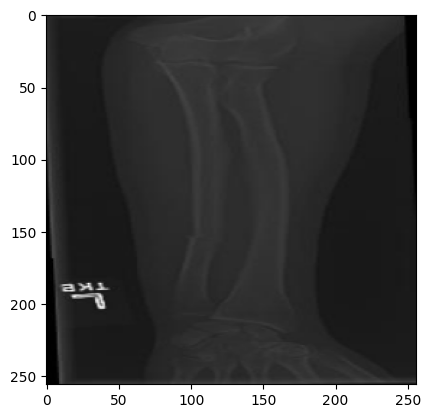

In [8]:
plt.imshow(X_train[0])

In [9]:
len(X_train)

1443

In [10]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=6)
y_val_one_hot = to_categorical(y_val, num_classes=6)

BATCH_SIZE = 32 


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow(X_train, y_train_one_hot, batch_size=BATCH_SIZE, shuffle=True)
validation_data = datagen.flow(X_val, y_val_one_hot, batch_size=BATCH_SIZE)

print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))

print("One-hot encoded y_train shape:", y_train_one_hot.shape)
print("One-hot encoded y_val shape:", y_val_one_hot.shape)

Training set size: 46
Validation set size: 12
One-hot encoded y_train shape: (1443, 6)
One-hot encoded y_val shape: (361, 6)


In [11]:
# model = keras.models.Sequential([
#     keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, 3, activation='relu'),
#     keras.layers.MaxPool2D(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(6, activation='softmax')
# ])

# model.summary()

In [12]:
# model.compile(
#     loss=keras.losses.CategoricalCrossentropy(from_logits=False),
#     optimizer=tf.keras.optimizers.Adam(),
#     metrics=['accuracy']
# )

In [13]:
# model.fit(
#     train_data,
#     validation_data=validation_data,
#     epochs=10
# )

In [14]:
# to solve the overfitting increase the dropout to 0.6 and using regularizers and make the learning rate =0.0005

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model = keras.models.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(6, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │       1,548,390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,548,838 (5.91 MB)

 Trainable params: 1,548,838 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


C:\Users\Subhodeep\Anaconda3\envs\myprojectenv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.2377 - loss: 1.9338 - val_accuracy: 0.3657 - val_loss: 1.6732
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.3823 - loss: 1.6343 - val_accuracy: 0.4017 - val_loss: 1.5511
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.5227 - loss: 1.4150 - val_accuracy: 0.4238 - val_loss: 1.4946
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.5628 - loss: 1.3014 - val_accuracy: 0.4875 - val_loss: 1.4499
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.6468 - loss: 1.1672 - val_accuracy: 0.4848 - val_loss: 1.4406
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.6763 - loss: 1.0898 - val_accuracy: 0.4571 - val_loss: 1.4633
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.6593 - loss: 1.0930 - val_accuracy: 0.5291 - val_loss: 1.3612
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.7124 - loss: 1.0005 - val_accuracy: 0.4931 -

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(validation_data)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5307 - loss: 1.3719
Test Loss: 1.3611584901809692
Test Accuracy: 0.5290858745574951


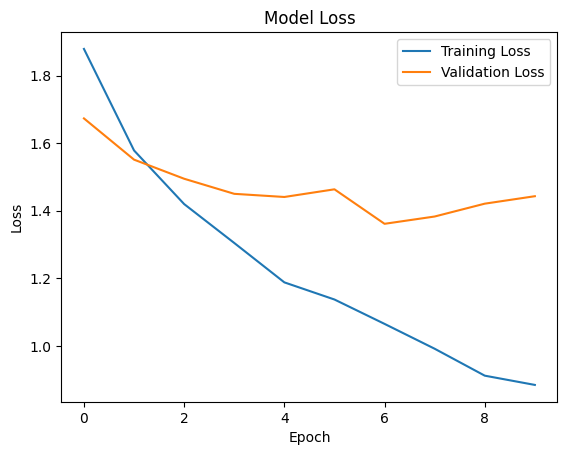

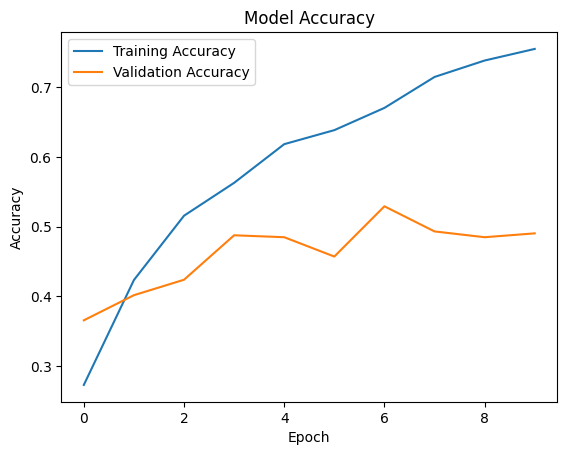

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values if accuracy was used as a metric
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()